In [212]:
# Import library yang kalian butuhkan
%pip install opencv-python matplotlib numpy pandas scikit-learn scikit-image scipy seaborn --quiet
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Jumlah data: 200
Jumlah kelas: 2


Text(0.5, 1.0, 'Leaf Blast')

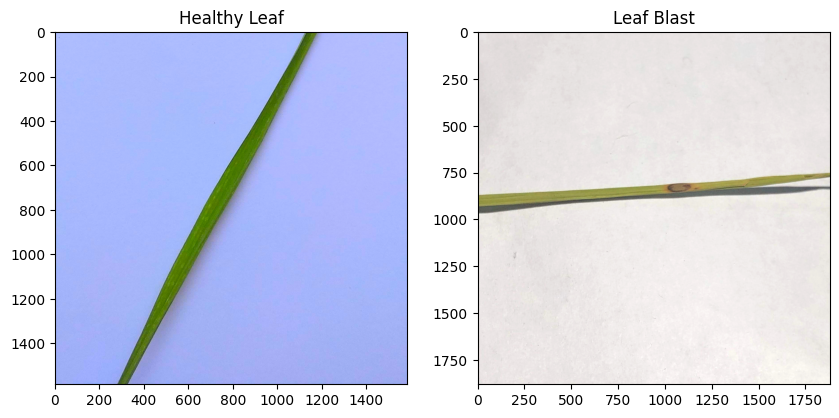

In [213]:
def resize_citra(gambar, ukuran):
    h, w = gambar.shape[:2]
    # siapkan array keluaran dengan channel sama
    if gambar.ndim == 3:
        c = gambar.shape[2]
        keluaran = np.zeros((ukuran, ukuran, c), dtype=gambar.dtype)
    else:
        keluaran = np.zeros((ukuran, ukuran), dtype=gambar.dtype)
    # nearest-neighbor manual
    for i in range(ukuran):
        for j in range(ukuran):
            src_i = int(i * h / ukuran)
            src_j = int(j * w / ukuran)
            keluaran[i, j] = gambar[src_i, src_j]
    return keluaran

data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset/"):
    if sub_folder.startswith("."):
        continue

    sub_folder_path = os.path.join("dataset/", sub_folder)
    if os.path.isdir(sub_folder_path):  # Ensure it's a directory
        sub_folder_files = os.listdir(sub_folder_path)
        for filename in sub_folder_files:
            img_path = os.path.join(sub_folder_path, filename)

            # img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
            img = plt.imread(img_path)
            resize_img = resize_citra(img, 256)

            data.append(resize_img)
            labels.append(sub_folder)
            name = os.path.splitext(filename)[0]
            file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)
print("Jumlah data:", len(data))
# Convert labels to categorical values
unique_labels = np.unique(labels)
label_to_index = {label: index for index, label in enumerate(unique_labels)}
labels = np.array([label_to_index[label] for label in labels])
print("Jumlah kelas:", len(unique_labels))

healthy = plt.imread("dataset/healthy/image1.jpg")
leafblast = plt.imread("dataset/leafblast/image1.jpg")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(healthy)
plt.title("Healthy Leaf")

plt.subplot(1, 2, 2)
plt.imshow(leafblast)
plt.title("Leaf Blast")

In [214]:
# melakukan augmentasi data
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
for i in range(len(data)):
	pass

In [215]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  200
Data setelah augmentasi:  0


In [ ]:
def ubah_ke_gray(gambar):
    if gambar.ndim == 3:
        return np.dot(gambar[..., :3], [0.2989, 0.5870, 0.1140])
    return gambar

def thresholding(image):
    baris, kolom = image.shape
    hasil = np.zeros((baris, kolom))
    for i in range(baris):
        for j in range(kolom):
            if image[i, j] > 155:
                hasil[i, j] = 255
            else:
                hasil[i, j] = 0
    return hasil

def meanprewitt(gambar):
    def padding5x5(image):
        return np.pad(image, pad_width=2, mode='edge')

    kernel5x5 = np.array([[1/25, 1/25, 1/25, 1/25, 1/25],
                        [1/25, 1/25, 1/25, 1/25, 1/25],
                        [1/25, 1/25, 1/25, 1/25, 1/25],
                        [1/25, 1/25, 1/25, 1/25, 1/25],
                        [1/25, 1/25, 1/25, 1/25, 1/25]])

    kernelPrewittX = np.array([[-1, 0, 1],
                            [-1, 0, 1],
                            [-1, 0, 1]])

    kernelPrewittY = np.array([[1, 1, 1],
                            [0, 0, 0],
                            [-1, -1, -1]])

    def mean5x5(image, kernel):
        img_pad = padding5x5(image)
        baris, kolom = image.shape
        hasil = np.zeros((baris, kolom))
        for i in range(baris):
            for j in range(kolom):
                temp = 0
                for k in range(kernel.shape[0]):
                    for l in range(kernel.shape[1]):
                        temp += img_pad[i+k, j+l] * kernel[k, l]
                hasil[i][j] = temp
        return hasil
    
    hasilmean5x5 = mean5x5(gambar, kernel5x5)

    def konvolusi_(image, kernel):
        pad = kernel.shape[0] // 2
        img_pad = np.pad(image, pad_width=pad, mode='constant', constant_values=0)
        baris, kolom = image.shape
        konv = np.zeros((baris, kolom))
        for i in range(baris):
            for j in range(kolom):
                for k in range(kernel.shape[0]):
                    for l in range(kernel.shape[1]):
                        konv[i, j] += img_pad[i+k, j+l] * kernel[k][l]
        return konv

    def deteksi(image, hasilX, hasilY):
        hasil = np.zeros(image.shape)
        hasil = np.sqrt(abs(pow(hasilX,2)) + abs(pow(hasilY,2)))
        return hasil

    premean5x5Rx = konvolusi_(hasilmean5x5, kernelPrewittX)
    premean5x5Ry = konvolusi_(hasilmean5x5, kernelPrewittY)
    pmean5x5 = deteksi(hasilmean5x5, premean5x5Rx, premean5x5Ry)

    return pmean5x5

def normalisasi(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image)) * 255

Text(0.5, 1.0, 'Leaf Blast')

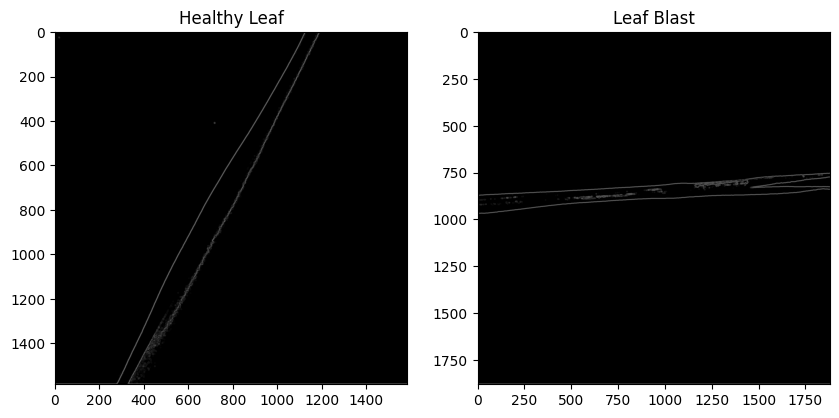

In [217]:
def percobaan1(gambar):
	gambar = ubah_ke_gray(gambar)
	gambar = thresholding(gambar)
	gambar = meanprewitt(gambar)
	gambar = normalisasi(gambar).astype(np.uint8)
	return gambar

dataPreprocessed = []
for i in range(len(data)):
	img = data[i]
	img = percobaan1(img)
	dataPreprocessed.append(img)

healthyP = percobaan1(healthy)
leafblastP = percobaan1(leafblast)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(healthyP, cmap='gray')
plt.title('Healthy Leaf')

plt.subplot(1, 2, 2)
plt.imshow(leafblastP, cmap='gray')
plt.title('Leaf Blast')


In [218]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [219]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [220]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [221]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [222]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [223]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [224]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [225]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [226]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [227]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [228]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [229]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [230]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [231]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [232]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [233]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [234]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [235]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,image1.jpg,0,557.488787,1097.736378,493.754381,1001.183637,0.911942,0.899511,0.917491,0.910950,...,0.817676,0.816256,0.900621,0.896649,0.904254,0.903469,0.738833,0.346816,0.770814,0.404268
1,image10.jpg,0,460.171553,962.287905,556.231403,1066.638047,0.915257,0.912563,0.910353,0.897127,...,0.809988,0.801612,0.903595,0.903281,0.899993,0.895328,0.784863,0.422103,0.733296,0.359437
2,image100.jpg,0,477.087653,1009.213226,563.463143,1069.390481,0.919440,0.903297,0.911955,0.896163,...,0.797776,0.791870,0.898531,0.893607,0.893183,0.889871,0.771437,0.374151,0.726298,0.336833
3,image11.jpg,0,434.253753,1019.780438,558.430852,963.649196,0.918858,0.892864,0.908568,0.900598,...,0.791784,0.790853,0.894870,0.885441,0.889823,0.889299,0.785584,0.341943,0.714669,0.378164
4,image12.jpg,0,492.629979,977.279862,554.948744,1111.780900,0.907180,0.922347,0.903917,0.892004,...,0.800676,0.790449,0.897010,0.899560,0.894805,0.889072,0.779294,0.444786,0.747630,0.368373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,image95.jpg,1,564.651225,1003.878877,486.655790,1091.527659,0.927297,0.924216,0.934729,0.915983,...,0.845117,0.833780,0.915633,0.918080,0.919302,0.913116,0.733718,0.398469,0.773007,0.345949
196,image96.jpg,1,559.155821,1017.813702,509.655362,1104.746298,0.936965,0.932666,0.941346,0.927210,...,0.862604,0.854841,0.926755,0.928361,0.928765,0.924576,0.720762,0.335477,0.746496,0.278719
197,image97.jpg,1,555.250123,1018.411565,509.157016,1097.249458,0.940695,0.936503,0.944842,0.931239,...,0.869946,0.862608,0.930745,0.932380,0.932709,0.928767,0.715397,0.310867,0.739959,0.257519
198,image98.jpg,1,562.534069,1005.461176,493.071461,1098.977855,0.924517,0.921626,0.931716,0.914779,...,0.841260,0.831091,0.914072,0.916438,0.917202,0.911642,0.736885,0.402242,0.771379,0.346645


<Axes: >

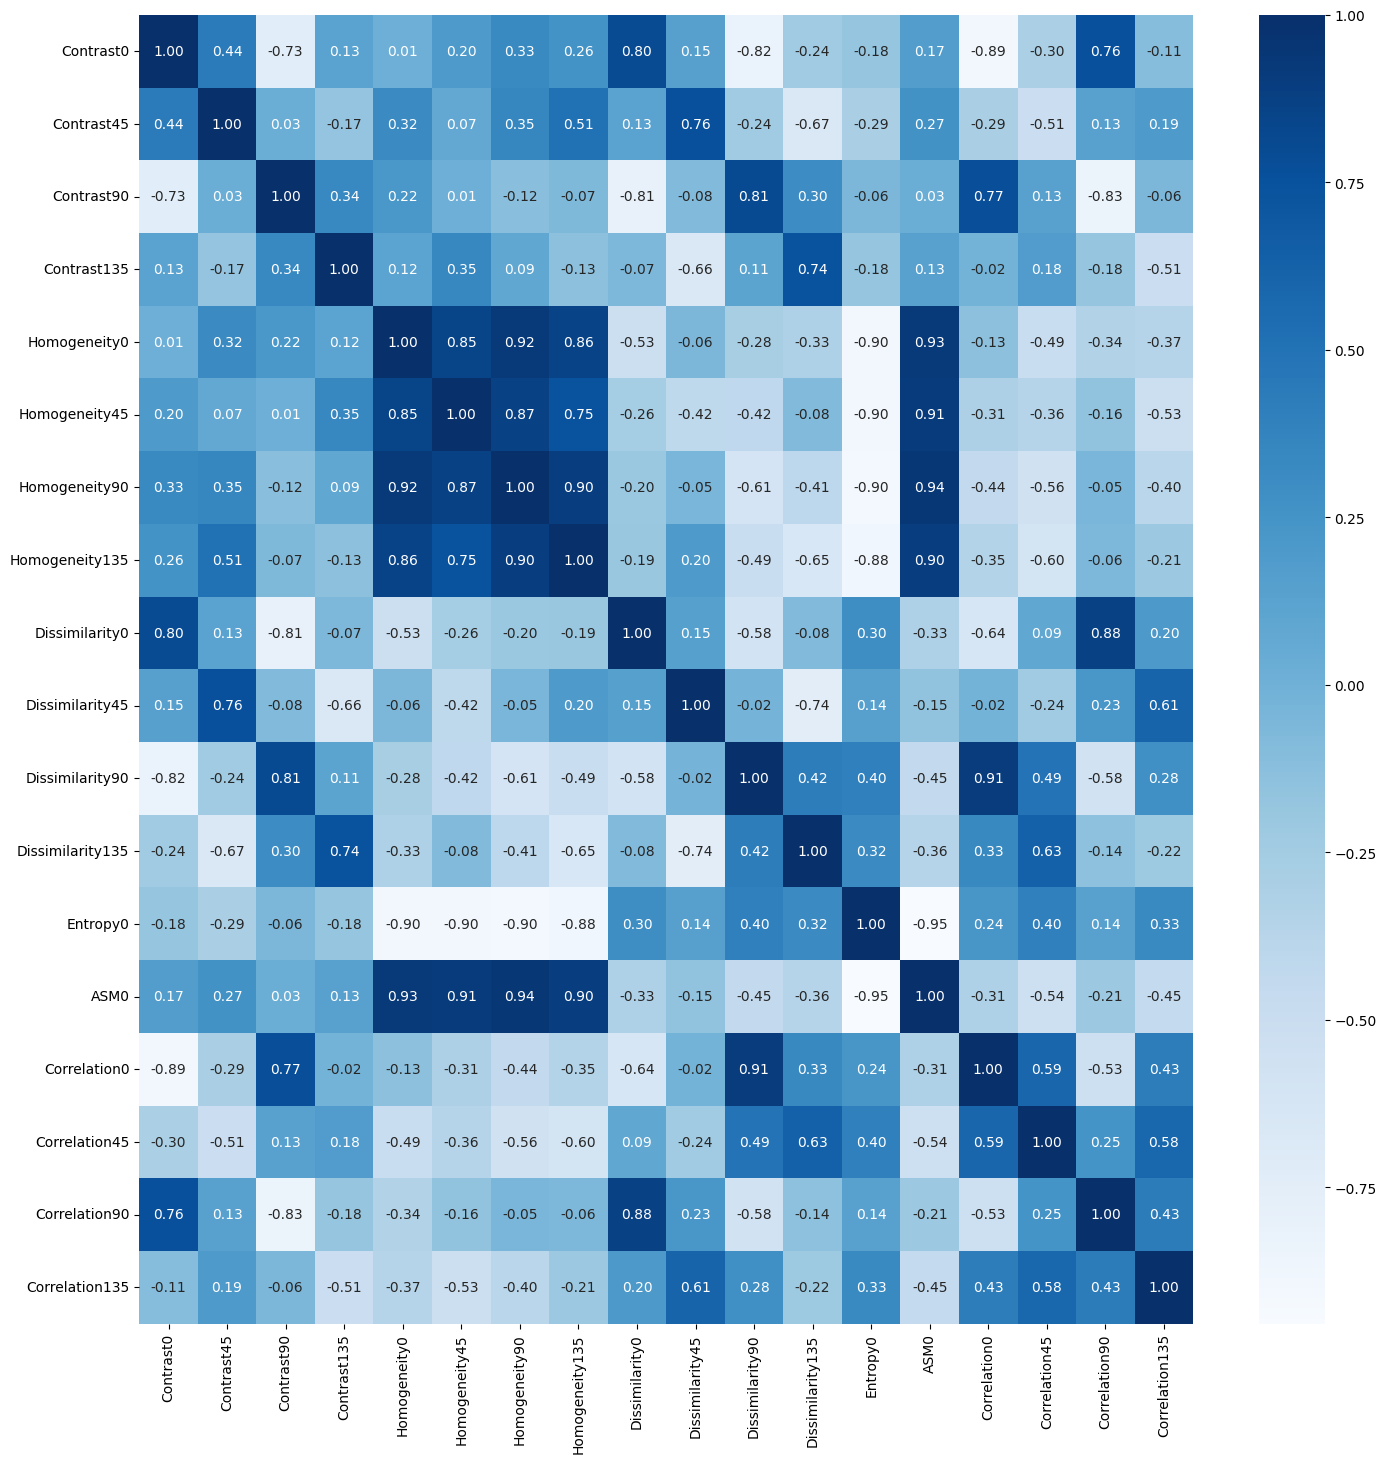

In [236]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

In [237]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(160, 18)
(40, 18)


In [238]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [239]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

In [240]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------


              precision    recall  f1-score   support

           0       0.99      0.96      0.97        79
           1       0.96      0.99      0.98        81

    accuracy                           0.97       160
   macro avg       0.98      0.97      0.97       160
weighted avg       0.98      0.97      0.97       160

[[76  3]
 [ 1 80]]
Accuracy: 0.975

------Testing Set------
              precision    recall  f1-score   support

           0       0.59      0.48      0.53        21
           1       0.52      0.63      0.57        19

    accuracy                           0.55        40
   macro avg       0.55      0.55      0.55        40
weighted avg       0.56      0.55      0.55        40

[[10 11]
 [ 7 12]]
Accuracy: 0.55


In [241]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------


              precision    recall  f1-score   support

           0       0.87      0.95      0.91        79
           1       0.95      0.86      0.90        81

    accuracy                           0.91       160
   macro avg       0.91      0.91      0.91       160
weighted avg       0.91      0.91      0.91       160

[[75  4]
 [11 70]]
Accuracy: 0.90625

------Testing Set------
              precision    recall  f1-score   support

           0       0.89      0.81      0.85        21
           1       0.81      0.89      0.85        19

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.85      0.85      0.85        40

[[17  4]
 [ 2 17]]
Accuracy: 0.85


In [242]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

           0       0.85      0.95      0.90        79
           1       0.94      0.84      0.89        81

    accuracy                           0.89       160
   macro avg       0.90      0.89      0.89       160
weighted avg       0.90      0.89      0.89       160

[[75  4]
 [13 68]]
Accuracy: 0.89375

------Testing Set------
              precision    recall  f1-score   support

           0       0.85      0.81      0.83        21
           1       0.80      0.84      0.82        19

    accuracy                           0.82        40
   macro avg       0.82      0.83      0.82        40
weighted avg       0.83      0.82      0.83        40

[[17  4]
 [ 3 16]]
Accuracy: 0.825


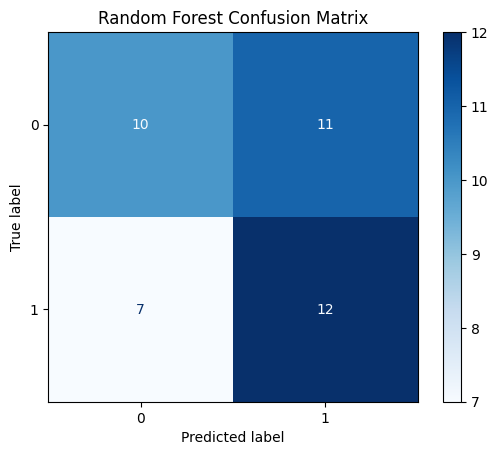

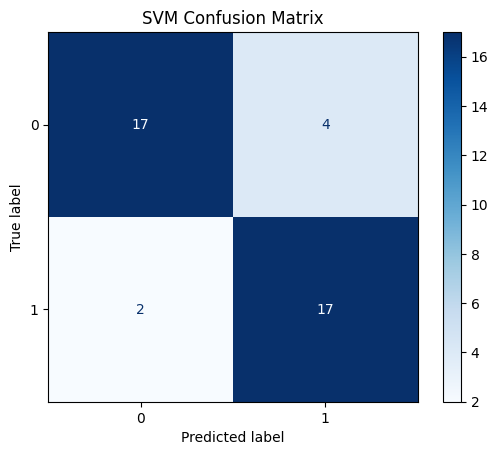

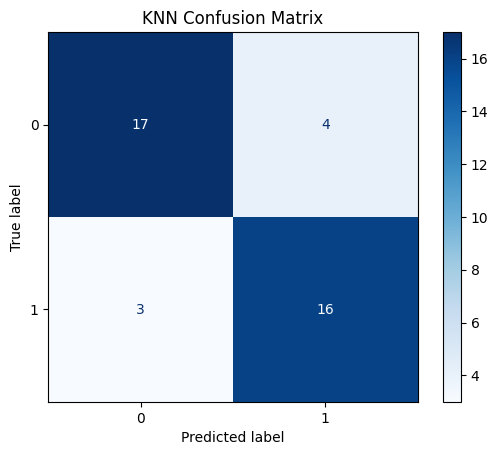

In [243]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")